<a href="https://colab.research.google.com/github/tizianofucci/A2NDLSegmentation/blob/main/Notebook/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

In [4]:
# Colab Pro
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Dec 28 12:08:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/New_Development_Dataset.zip

Archive:  /content/drive/MyDrive/New_Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Devel

In [7]:
cd drive/MyDrive

/content/drive/MyDrive


# Example: Image Segmentation
## Build segmentation

In [8]:
import sys
sys.path.append('/content/drive/MyDrive/starting_kit')


In [9]:
import read_mask_example as rme
import prepare_submission as ps
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"Development_Dataset")

# Save all possible path in order to be able to cycle over them
test_dir = {}
dataset_dir = {}
patches_dir = {}

dataset_dir[0] = os.path.join(cwd,'Training/Bipbip/Mais')
dataset_dir[1] = os.path.join(cwd,'Training/Bipbip/Haricot')

patches_dir[0] = '/content/drive/MyDrive/Mais'
patches_dir[1] = '/content/drive/MyDrive/Haricot'

test_dir[0] = os.path.join(cwd,'Test_Dev/Bipbip/Mais')
test_dir[1] = os.path.join(cwd,'Test_Dev/Bipbip/Haricot')
test_dir[2] = os.path.join(cwd,'Test_Dev/Pead/Mais')
test_dir[3] = os.path.join(cwd,'Test_Dev/Pead/Haricot')
test_dir[4] = os.path.join(cwd,'Test_Dev/Roseau/Mais')
test_dir[5] = os.path.join(cwd,'Test_Dev/Roseau/Haricot')
test_dir[6] = os.path.join(cwd,'Test_Dev/Weedelec/Mais')
test_dir[7] = os.path.join(cwd,'Test_Dev/Weedelec/Haricot')

crops = {}

crops[0] = "Mais"
crops[1] = "Haricot"

teams = {}

teams[0] = "Bipbip"
teams[1] = "Pead"
teams[2] = "Roseau"
teams[3] = "Weedelec"


In [10]:
print(dataset_dir)
print(test_dir)

{0: '/content/drive/Development_Dataset/Training/Bipbip/Mais', 1: '/content/drive/Development_Dataset/Training/Bipbip/Haricot'}
{0: '/content/drive/Development_Dataset/Test_Dev/Bipbip/Mais', 1: '/content/drive/Development_Dataset/Test_Dev/Bipbip/Haricot', 2: '/content/drive/Development_Dataset/Test_Dev/Pead/Mais', 3: '/content/drive/Development_Dataset/Test_Dev/Pead/Haricot', 4: '/content/drive/Development_Dataset/Test_Dev/Roseau/Mais', 5: '/content/drive/Development_Dataset/Test_Dev/Roseau/Haricot', 6: '/content/drive/Development_Dataset/Test_Dev/Weedelec/Mais', 7: '/content/drive/Development_Dataset/Test_Dev/Weedelec/Haricot'}


In [11]:
dataset_dir = {0: '/content/Development_Dataset/Training/Bipbip/Mais', 1: '/content/Development_Dataset/Training/Bipbip/Haricot'}
test_dir = {0: '/content/Development_Dataset/Test_Dev/Bipbip/Mais', 1: '/content/Development_Dataset/Test_Dev/Bipbip/Haricot', 2: '/content/Development_Dataset/Test_Dev/Pead/Mais', 3: '/content/Development_Dataset/Test_Dev/Pead/Haricot', 4: '/content/Development_Dataset/Test_Dev/Roseau/Mais', 5: '/content/Development_Dataset/Test_Dev/Roseau/Haricot', 6: '/content/Development_Dataset/Test_Dev/Weedelec/Mais', 7: '/content/Development_Dataset/Test_Dev/Weedelec/Haricot'}


from PIL import Image
import shutil

tf.compat.v1.disable_eager_execution()
img_h_ = 1536
img_w_ = 2048


img_h = 768
img_w = 512

create_patches = True

if (create_patches == True) :
  for i in range(0,2):
      image_filenames = next(os.walk(os.path.join(dataset_dir[i],"Images/")))[2]
      for image_name in image_filenames:
      
      
      
          image_name=image_name[:-4]
          img = Image.open(os.path.join(dataset_dir[i], 'Images', image_name + ".jpg"))
          mask = Image.open(os.path.join(dataset_dir[i], 'Masks', image_name + '.png'))

          # Resize image and mask
          img = img.resize([img_w_,img_h_])
          
          img_arr = tf.expand_dims(np.array(img), 0)
          


          mask_arr = tf.expand_dims(np.array(mask), 0)



          patches = tf.image.extract_patches(images=img_arr,
                            sizes=[1, img_h, img_w, 1],
                            strides=[1, img_h-10, img_w-10, 1],
                            rates=[1, 1, 1, 1],
                            padding='VALID')
          
          patches_mask = tf.image.extract_patches(images=mask_arr,
                            sizes=[1, img_h, img_w, 1],
                            strides=[1, img_h-10, img_w-10, 1],
                            rates=[1, 1, 1, 1],
                            padding='VALID')
          patches = tf.reshape(patches, [8, 768, 512, 3])

          patches_mask = tf.reshape(patches_mask, [8, 768, 512, 3])


          for j in range(0,8):
            image = tf.io.encode_jpeg(patches[j])
            writer = tf.io.write_file(os.path.join(patches_dir[i], 'Images',image_name+'patch'+str(j)+'.jpg'),image)
            with tf.compat.v1.Session() as sess:
              sess.run(writer)

            msk = tf.io.encode_png(patches_mask[j])
            writer = tf.io.write_file(os.path.join(patches_dir[i], 'Masks',image_name+'patch'+str(j)+'.png'), msk)
            with tf.compat.v1.Session() as sess:
              sess.run(writer)
else:
  for i in range(0,2):
    
    tf.compat.v1.gfile.DeleteRecursively(os.path.join(dataset_dir[i], 'Images'))
    tf.compat.v1.gfile.DeleteRecursively(os.path.join(dataset_dir[i], 'Masks'))
    shutil.copytree(os.path.join(patches_dir[i], 'Masks'), os.path.join(dataset_dir[i], 'Masks'))
    shutil.copytree(os.path.join(patches_dir[i], 'Images'), os.path.join(dataset_dir[i], 'Images'))

In [12]:
#!zip -r "/content/drive/MyDrive/New_Development_Dataset.zip" "/content/Development_Dataset"

In [13]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [14]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.mask_generator = mask_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        mask_arr = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'),self.out_shape)
        #print(mask_arr.shape)
  

        mask_arr = np.expand_dims(mask_arr, -1)

        if self.which_subset == 'training':
            if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
                mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
                img_arr = self.img_generator.apply_transform(img_arr, img_t)
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
                out_mask = np.zeros_like(mask_arr)
                for c in np.unique(mask_arr):
                    if c > 0:
                        curr_class_arr = np.float32(mask_arr == c)
                        curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
                        # from [0, 1] to {0, 1}
                        curr_class_arr = np.uint8(curr_class_arr)
                        # recover original class
                        curr_class_arr = curr_class_arr * c 
                        out_mask += curr_class_arr
        else:
            out_mask = mask_arr
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        return img_arr, np.float32(out_mask)

In [15]:
for j in range (0,2):
    if not os.path.exists(os.path.join(dataset_dir[j],"Splits/")):
        os.makedirs(os.path.join(dataset_dir[j],"Splits/"))


    image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]
    
    val=[]
    train=[]
    
    for image_name in image_filenames:
        if 100*random.random() < 10:
            val.append(image_name[:-4])
        else:
            train.append(image_name[:-4])
    
    with open(os.path.join(dataset_dir[j],"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
        for i in train:
            file.write(str(i)+"\n")
    
    with open(os.path.join(dataset_dir[j],"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
        for i in val:
            file.write(str(i)+"\n")

   

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

27

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

30

In [84]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 768
img_w = 512

dataset = CustomDataset(dataset_dir[0], 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, out_shape=[img_w,img_h])

#dataset1 = CustomDataset(dataset_dir[1], 'training', 
#                        img_generator=img_data_gen, mask_generator=mask_data_gen,
#                        preprocessing_function=None, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(dataset_dir[0], 'validation', 
                              preprocessing_function=preprocess_input,out_shape=[img_w,img_h])

#dataset_valid1 = CustomDataset(dataset_dir[1], 'validation', 
#                              preprocessing_function=None,out_shape=[img_w,img_h])


In [85]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)

train_dataset0 = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

#train_dataset1 = tf.data.Dataset.from_generator(lambda: dataset1,
#                                               output_types=(tf.float32, tf.float32),
#                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

#train_dataset = train_dataset0.concatenate(train_dataset1)

train_dataset0 = train_dataset0.batch(5)

train_dataset0 = train_dataset0.repeat()

valid_dataset0 = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
#valid_dataset1 = tf.data.Dataset.from_generator(lambda: dataset_valid1,
#                                               output_types=(tf.float32, tf.float32),
#                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

#valid_dataset = valid_dataset0.concatenate(valid_dataset1)

valid_dataset0 = valid_dataset0.batch(5)

valid_dataset0 = valid_dataset0.repeat()

In [86]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset0)

[0. 2.]


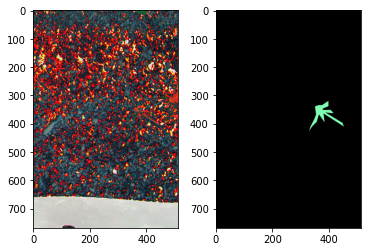

2


In [87]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

print(np.max(np.uint8(target)))

In [88]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 768, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 192, 128, 128)     0     

In [89]:
def show_predictions(dataset=None, num=1):
    iterator = iter(valid_dataset0)
    fig, ax = plt.subplots(1, 3, figsize=(8, 8))
    fig.show()
    image, target = next(iterator)

    image = image[0]
    target = target[0, ..., 0]

    out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(out_sigmoid, -1)

    out_sigmoid.shape

    predicted_class = predicted_class[0, ...]

    # Assign colors (just for visualization)
    target_img = np.zeros([target.shape[0], target.shape[1], 3])
    prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

    target_img[np.where(target == 0)] = [0, 0, 0]
    for i in range(1, 3):
      target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

    prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
    for i in range(1, 3):
      prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

    ax[0].imshow(np.uint8(image))
    ax[1].imshow(np.uint8(target_img))
    ax[2].imshow(np.uint8(prediction_img))

    fig.canvas.draw()
    time.sleep(1)

In [91]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [94]:
# This function is used for creating a model without skip connections
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [95]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """
      creates an upsample layer for the model, 
  """
  initializer = tf.keras.initializers.GlorotNormal()

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
  result.add(tf.keras.layers.Conv2D(filters=filters,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same', kernel_initializer=initializer))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
from IPython.display import clear_output

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

base_model = vgg

# Use the activations of these layers
layer_names = [
    'block1_conv2',
    'block2_conv2',  
    'block3_conv3',   
    'block4_conv3', 
    'block5_conv3',      
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


up_stack = [
    upsample(512, 3), 
    upsample(256, 3), 
    upsample(128, 3),
    upsample(64, 3) 
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[img_h, img_w, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2D(filters=output_channels,
                                         kernel_size=(1, 1),
                                         strides=(1, 1),
                                         padding='same',
                                         activation='softmax') 

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(3)

In [ ]:
# To use U-Net without backbone
# Visualize created model as a table

# Randomly initializes the weights, drawing them from a normal distribution
# initializer = tf.keras.initializers.GlorotNormal()

# def get_crop_shape(target, refer):
#         # width, the 3rd dimension
#         cw = (target.get_shape()[2] - refer.get_shape()[2])
#         assert (cw >= 0)
#         if cw % 2 != 0:
#             cw1, cw2 = int(cw/2), int(cw/2) + 1
#         else:
#             cw1, cw2 = int(cw/2), int(cw/2)
#         # height, the 2nd dimension
#         ch = (target.get_shape()[1] - refer.get_shape()[1])
#         assert (ch >= 0)
#         if ch % 2 != 0:
#             ch1, ch2 = int(ch/2), int(ch/2) + 1
#         else:
#             ch1, ch2 = int(ch/2), int(ch/2)

#         return (ch1, ch2), (cw1, cw2)


# concat_axis = 3
# inputs = tf.keras.layers.Input(shape = [img_h,img_w,3])

# conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1', kernel_initializer=initializer)(inputs)
# conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv1)
# pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool1)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv2)
# pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool2)
# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv3)
# pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool3)
# conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv4)
# pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

# conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool4)
# conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv5)

# up_conv5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
# ch, cw = get_crop_shape(conv4, up_conv5)
# crop_conv4 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv4)
# up6 = tf.keras.layers.concatenate([up_conv5, crop_conv4], axis=concat_axis)
# conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up6)
# conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv6)

# up_conv6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
# ch, cw = get_crop_shape(conv3, up_conv6)
# crop_conv3 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv3)
# up7 = tf.keras.layers.concatenate([up_conv6, crop_conv3], axis=concat_axis) 
# conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up7)
# conv7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv7)

# up_conv7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv7)
# ch, cw = get_crop_shape(conv2, up_conv7)
# crop_conv2 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv2)
# up8 = tf.keras.layers.concatenate([up_conv7, crop_conv2], axis=concat_axis)
# conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up8)
# conv8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv8)

# up_conv8 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv8)
# ch, cw = get_crop_shape(conv1, up_conv8)
# crop_conv1 = tf.keras.layers.Cropping2D(cropping=(ch,cw))(conv1)
# up9 = tf.keras.layers.concatenate([up_conv8, crop_conv1], axis=concat_axis)
# conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up9)
# conv9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv9)

# ch, cw = get_crop_shape(inputs, conv9)
# conv9 = tf.keras.layers.ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
# conv10 = tf.keras.layers.Conv2D(3, (1, 1), kernel_initializer=initializer)(conv9)

# model = tf.keras.models.Model(inputs=inputs, outputs=conv10)

# Visualize created model as a table

In [ ]:
# To use VGG without skip connections
# model = create_model(depth=5, 
#                       start_f=8, 
#                       num_classes=3)

In [ ]:
model.summary()

In [97]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 8e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------
weights = [1.1,2.1,2.6]

# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics, loss_weights=weights)

In [105]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU', patience=10, mode="max")
    callbacks.append(es_callback)

model.fit(x=train_dataset0,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),#+len(dataset1)
          validation_data=valid_dataset0,
          validation_steps=len(dataset_valid), #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
641/641 [==============================] - 1041s 2s/step - loss: 1.3021 - accuracy: 0.9661 - meanIoU: 0.7138 - val_loss: 1.5697 - val_accuracy: 0.9588 - val_meanIoU: 0.6653
Epoch 2/100
 27/641 [>.............................] - ETA: 15:49 - loss: 1.2082 - accuracy: 0.9655 - meanIoU: 0.7013

KeyboardInterrupt: ignored

import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

(1, 768, 512, 3)

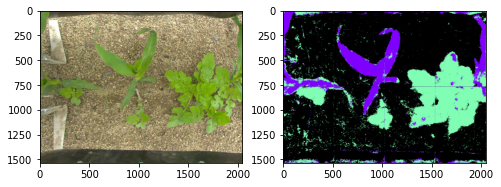

In [106]:
#model.load_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

image = Image.open(os.path.join(test_dir[0], 'Images/Bipbip_mais_im_03621.jpg'))
#mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
         

img_arr = preprocess_input( tf.expand_dims(np.array(image), 0))


patches = tf.image.extract_patches(images=img_arr,
                        sizes=[1, img_h, img_w, 1],
                        strides=[1, img_h, img_w, 1],
                        rates=[1, 1, 1, 1],
                        padding='VALID')
patches = tf.reshape(patches, [8, 768, 512, 3])


# Resize image and mask
#image = image.resize([img_w,img_h])

predictions = []

for j in range (0,8):
    out_sigmoid = model.predict(x=tf.expand_dims(patches[j],0))

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(out_sigmoid, -1)

    out_sigmoid.shape

    predicted_class = predicted_class[0, ...]

    prediction_img = np.zeros([img_h, img_w, 3])


    prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
    for i in range(1, 3):
      prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

#     ax[0].imshow(np.uint8(patches[j]))
#     ax[1].imshow(np.uint8(prediction_img))

    predictions.append(prediction_img)
    
    fig.canvas.draw()
    time.sleep(1)
    
total = tf.concat([predictions[0], predictions[4]], 0)

for x in range (1,4):
    result=tf.concat([predictions[x], predictions[x+4]], 0)
    total=tf.concat([total, result], 1)
    
ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(total))

In [104]:
#Create submission
submission_dict = {} 

for i in range(0,8):
    image_filenames = next(os.walk(os.path.join(test_dir[i],"Images/")))[2]

    if i in range(4,6):
        suffix = ".png"
    else:
        suffix = ".jpg"
    
    print (suffix)
    for image_name in image_filenames:
    
    
        image_name=image_name[:-4]
        img = Image.open(os.path.join(test_dir[i], 'Images', image_name + suffix))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        # Resize image and mask
        img = img.resize([2048,1536])
        

        
        # mask = mask.resize(self.out_shape)
    
        img_arr = preprocess_input( tf.expand_dims(np.array(img), 0))


        patches = tf.image.extract_patches(images=img_arr,
                                sizes=[1, img_h, img_w, 1],
                                strides=[1, img_h, img_w, 1],
                                rates=[1, 1, 1, 1],
                                padding='VALID')
        patches = tf.reshape(patches, [8, 768, 512, 3])


        # Resize image and mask
        #image = image.resize([img_w,img_h])

        predictions = []

        for j in range (0,8):
            out_sigmoid = model.predict(x=tf.expand_dims(patches[j],0))

            # Get predicted class as the index corresponding to the maximum value in the vector probability
            # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
            # predicted_class = predicted_class[0, ..., 0]
            predicted_class = np.argmax(out_sigmoid, -1)
            predicted_class = predicted_class[0, ...]

        #     ax[0].imshow(np.uint8(patches[j]))
        #     ax[1].imshow(np.uint8(prediction_img))

            predictions.append(predicted_class)



        total = tf.concat([predictions[0], predictions[4]], 0)

        for x in range (1,4):
            result=tf.concat([predictions[x], predictions[x+4]], 0)
            total=tf.concat([total, result], 1)
    
        mask_arr = np.array(total)
        submission_dict[image_name] = {}
        submission_dict[image_name]['shape'] = [1536,2048]
        submission_dict[image_name]['team'] = teams[math.floor(i/2)]
        submission_dict[image_name]['crop'] = crops[i%2]
        submission_dict[image_name]['segmentation'] = {}

        # RLE encoding
        # crop
        rle_encoded_crop = ps.rle_encode(mask_arr == 1)
        # weed
        rle_encoded_weed = ps.rle_encode(mask_arr == 2)

        submission_dict[image_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[image_name]['segmentation']['weed'] = rle_encoded_weed

        # Finally, save the results into the submission.json file
with open(os.path.join(dataset_dir[0],"submission.json"), 'w') as f:
    json.dump(submission_dict, f)

.jpg
.jpg
.jpg
.jpg
.png
.png
.jpg
.jpg


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [107]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))
